# **Modelo predictivo de la demanda a nivel de ítem: Caso Walmart**
### **Autor:** Andrés Ulloa J.

## **Importar librerías**

In [3]:
# Importar librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV
import lightgbm as lgb
from lightgbm import LGBMRegressor
import itertools
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
import joblib

import warnings
warnings.filterwarnings("ignore")

## **Cargar conjunto de datos**

In [5]:
# Cargar conjunto de datos a nivel de ítem
df_foods_2_347_agg = pd.read_csv("df_foods_2_347_agg.csv")

In [6]:
# Convertir la columna 'date' a tipo datetime.
df_foods_2_347_agg['date'] = pd.to_datetime(df_foods_2_347_agg['date'])

In [7]:
df_foods_2_347_agg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1097 entries, 0 to 1096
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   date                     1097 non-null   datetime64[ns]
 1   sales_total              1097 non-null   int64         
 2   sell_price               1097 non-null   float64       
 3   snap_CA                  1097 non-null   int64         
 4   sales_lag_1              1097 non-null   float64       
 5   sales_lag_2              1097 non-null   float64       
 6   month                    1097 non-null   int64         
 7   week_of_year             1097 non-null   int64         
 8   sales_moving_avg         1097 non-null   float64       
 9   price_promo_interaction  1097 non-null   float64       
 10  cumulative_sales         1097 non-null   int64         
 11  day_of_week              1097 non-null   int64         
 12  price_volatility         1097 non-

## Exploración de datos

Vamos a partir por una breve descripción de las variables contenidas en el conjunto de datos:

In [10]:
df_foods_2_347_agg.describe()

,date,sales_total,sell_price,snap_CA,sales_lag_1,sales_lag_2,month,week_of_year,sales_moving_avg,price_promo_interaction,cumulative_sales,day_of_week,price_volatility,quarter
count,1097,1097.000000,1097.000000,1097.000000,1097.000000,1097.000000,1097.000000,1097.000000,1097.000000,1097.000000,1097.000000,1097.000000,1097.000000,1097.000000
mean,2014-11-21 00:00:00,12.175934,2.035661,0.328168,12.174111,12.170465,6.520510,26.679125,12.174643,0.667274,6854.679125,3.004558,0.000345,2.507748
min,2013-05-22 00:00:00,0.000000,2.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,7.000000,0.000000,0.000000,1.000000
25%,2014-02-20 00:00:00,8.000000,2.000000,0.000000,8.000000,8.000000,4.000000,14.000000,9.500000,0.000000,3293.000000,1.000000,0.000000,2.000000
50%,2014-11-21 00:00:00,12.000000,2.000000,0.000000,12.000000,12.000000,7.000000,27.000000,12.000000,0.000000,7029.000000,3.000000,0.000000,3.000000
75%,2015-08-22 00:00:00,16.000000,2.000000,1.000000,16.000000,16.000000,10.000000,40.000000,14.500000,2.000000,10323.000000,5.000000,0.000000,4.000000
max,2016-05-22 00:00:00,66.000000,2.240000,1.000000,66.000000,66.000000,12.000000,53.000000,48.750000,2.240000,13357.000000,6.000000,0.138564,4.000000
std,NaN,7.541917,0.085402,0.469760,7.542927,7.544462,3.449292,15.126988,4.920004,0.956363,3953.730781,1.999767,0.006609,1.117293


In [11]:
df_foods_2_347_agg.corr()

,date,sales_total,sell_price,snap_CA,sales_lag_1,sales_lag_2,month,week_of_year,sales_moving_avg,price_promo_interaction,cumulative_sales,day_of_week,price_volatility,quarter
date,1.000000,-0.071250,0.616058,-0.001839,-0.069491,-0.068149,-0.142656,-0.127720,-0.106187,0.015217,0.999338,0.002373,0.063759,-0.137969
sales_total,-0.071250,1.000000,-0.076385,0.111940,0.313754,0.197076,0.029796,0.017330,0.605204,0.109094,-0.068563,0.177322,-0.084410,0.024471
sell_price,0.616058,-0.076385,1.000000,-0.019057,-0.079333,-0.082854,-0.305406,-0.285901,-0.124408,0.008671,0.597149,0.005458,0.125031,-0.306973
snap_CA,-0.001839,0.111940,-0.019057,1.000000,0.109261,0.085635,-0.004158,-0.046928,0.138616,0.998762,-0.001759,-0.011306,-0.036544,-0.004849
sales_lag_1,-0.069491,0.313754,-0.079333,0.109261,1.000000,0.314018,0.026602,0.024080,0.699348,0.107194,-0.066239,0.061282,-0.084386,0.019923
sales_lag_2,-0.068149,0.197076,-0.082854,0.085635,0.314018,1.000000,0.027722,0.018284,0.699432,0.083746,-0.064533,-0.187406,-0.084344,0.021870
month,-0.142656,0.029796,-0.305406,-0.004158,0.026602,0.027722,1.000000,0.956402,0.040146,-0.015769,-0.136259,-0.009736,0.083005,0.971409
week_of_year,-0.127720,0.017330,-0.285901,-0.046928,0.024080,0.018284,0.956402,1.000000,0.029318,-0.056742,-0.121607,-0.000856,0.081652,0.934459
sales_moving_avg,-0.106187,0.605204,-0.124408,0.138616,0.699348,0.699432,0.040146,0.029318,1.000000,0.135803,-0.101106,-0.066819,-0.129379,0.032777
price_promo_interaction,0.015217,0.109094,0.008671,0.998762,0.107194,0.083746,-0.015769,-0.056742,0.135803,1.000000,0.014781,-0.011019,-0.036499,-0.016114


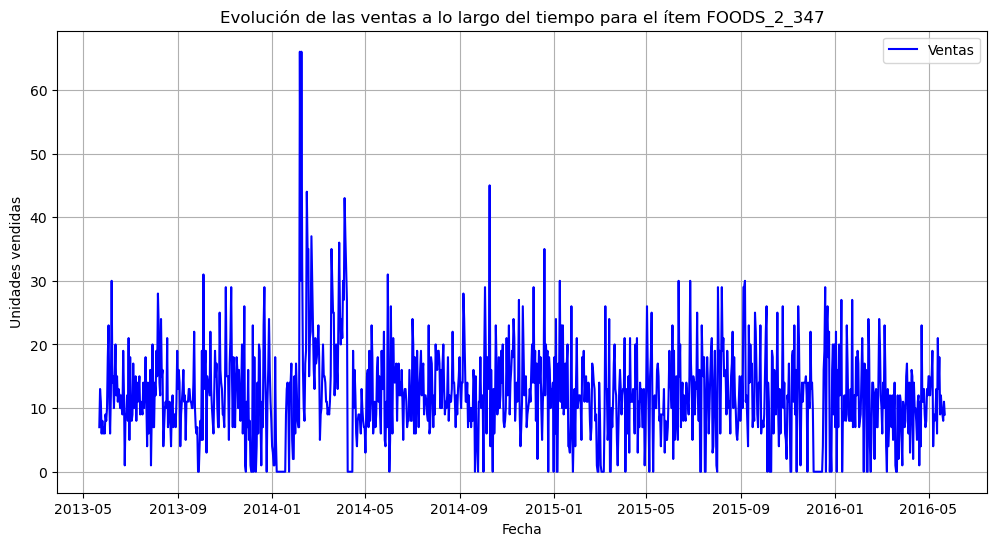

In [12]:
plt.figure(figsize=(12, 6))

# Graficamos ventas diarias
plt.plot(df_foods_2_347_agg['date'], df_foods_2_347_agg['sales_total'], label='Ventas', color='blue')

plt.title('Evolución de las ventas a lo largo del tiempo para el ítem FOODS_2_347')
plt.xlabel('Fecha')
plt.ylabel('Unidades vendidas')
plt.legend()
plt.grid(True)
plt.show()

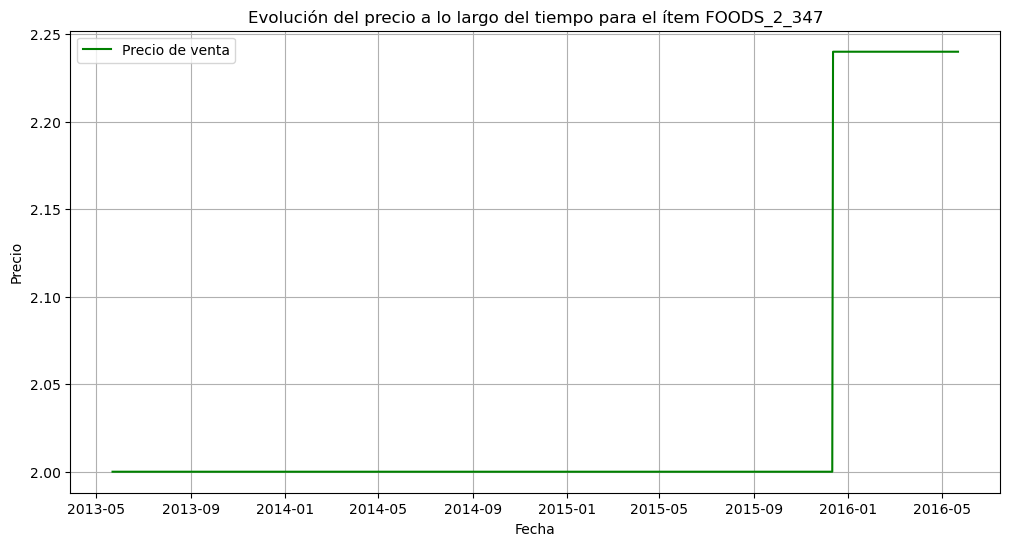

In [13]:
plt.figure(figsize=(12, 6))

# Graficamos el precio de venta
plt.plot(df_foods_2_347_agg['date'], df_foods_2_347_agg['sell_price'], label='Precio de venta', color='green')

plt.title('Evolución del precio a lo largo del tiempo para el ítem FOODS_2_347')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.legend()
plt.grid(True)
plt.show()

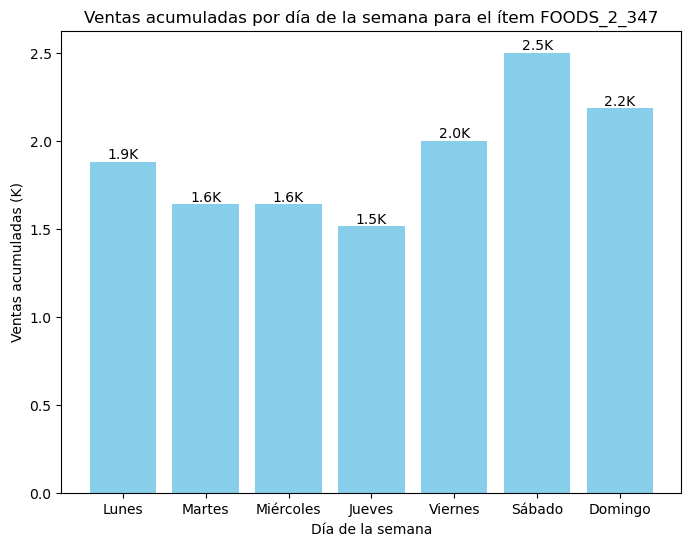

In [14]:
# Agrupamos las ventas por día de la semana
sales_by_day = df_foods_2_347_agg.groupby('day_of_week')['sales_total'].sum()

# Definimos los nombres de los días de la semana
days = ['Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']

plt.figure(figsize=(8, 6))

# Graficamos las ventas acumuladas por día de la semana
bars = plt.bar(days, sales_by_day / 1000, color='skyblue')  # Dividimos entre 1000 para representar en miles (K)

# Agregamos etiquetas en las barras
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.1f}K', ha='center', va='bottom')

plt.title('Ventas acumuladas por día de la semana para el ítem FOODS_2_347')
plt.xlabel('Día de la semana')
plt.ylabel('Ventas acumuladas (K)')
plt.show()

## **Primer modelo predictivo LightGBM a nivel de ítem (foods_2_347)**

In [16]:
# Establecer la columna 'date' como índice
df_foods_2_347_agg.set_index('date', inplace=True)

In [17]:
# Paso 1: Definir la variable objetivo y las características
target = 'sales_total'
features = df_foods_2_347_agg.columns.drop(target)

In [18]:
# Paso 2: Dividir los datos en entrenamiento y prueba (últimos 12 meses para test)
test_size = 365  # Últimos 12 meses
train = df_foods_2_347_agg.iloc[:-test_size]  # Todo menos los últimos 12 meses para entrenamiento
test = df_foods_2_347_agg.iloc[-test_size:]   # Los últimos 12 meses para prueba

In [19]:
# Features y variable objetivo
X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

In [20]:
# Paso 3: Preparar los datasets para LightGBM
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

In [21]:
# Paso 4: Definir el espacio de búsqueda de hiperparámetros
param_dist = {
    'num_leaves': np.arange(20, 150, 10),
    'max_depth': np.arange(3, 15, 1),
    'learning_rate': np.linspace(0.01, 0.3, 10),
    'n_estimators': np.arange(50, 300, 50),
    'subsample': np.linspace(0.6, 1.0, 5),
    'colsample_bytree': np.linspace(0.6, 1.0, 5),
    'reg_alpha': np.linspace(0, 1, 10),
    'reg_lambda': np.linspace(0, 1, 10)
}

In [22]:
# Paso 5: Crear el modelo LightGBM con el envoltorio de Scikit-Learn
model_lgb = lgb.LGBMRegressor(boosting_type='gbdt', objective='regression', verbose=-1)  # Silenciar LightGBM

In [23]:
# Paso 6: Configurar la búsqueda aleatoria con validación cruzada
random_search = RandomizedSearchCV(
    estimator=model_lgb, 
    param_distributions=param_dist,
    n_iter=50,  # Número de combinaciones a probar
    scoring='neg_mean_squared_error',  # Métrica de evaluación
    cv=3,  # Validación cruzada
    verbose=0,  # Evitar mensajes durante la optimización
    random_state=42,
    n_jobs=-1  # Usar todos los núcleos disponibles para acelerar
)

In [24]:
# Paso 7: Ajustar el modelo usando RandomizedSearchCV
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=LGBMRegressor(objective='regression', verbose=-1),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'colsample_bytree': array([0.6, 0.7, 0.8, 0.9, 1. ]),
                                        'learning_rate': array([0.01      , 0.04222222, 0.07444444, 0.10666667, 0.13888889,
       0.17111111, 0.20333333, 0.23555556, 0.26777778, 0.3       ]),
                                        'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
                                        'n_esti...
                                        'num_leaves': array([ 20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130, 140]),
                                        'reg_alpha': array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ]),
                                        'reg_lambda': array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ]),
                                        'subsample': array([0.6, 0.7, 0.8, 0.9, 1. ])},
                   random_state=42, scoring='neg_mean_squared_error')

In [25]:
# Ver los mejores hiperparámetros encontrados
print(f'Mejores hiperparámetros: {random_search.best_params_}')

Mejores hiperparámetros: {'subsample': 0.6, 'reg_lambda': 0.4444444444444444, 'reg_alpha': 0.8888888888888888, 'num_leaves': 50, 'n_estimators': 50, 'max_depth': 14, 'learning_rate': 0.07444444444444444, 'colsample_bytree': 0.9}


In [26]:
# Paso 8: Entrenar el modelo con los mejores hiperparámetros
best_model = random_search.best_estimator_

In [27]:
# Paso 9: Hacer predicciones con el conjunto de prueba
predicciones = best_model.predict(X_test)

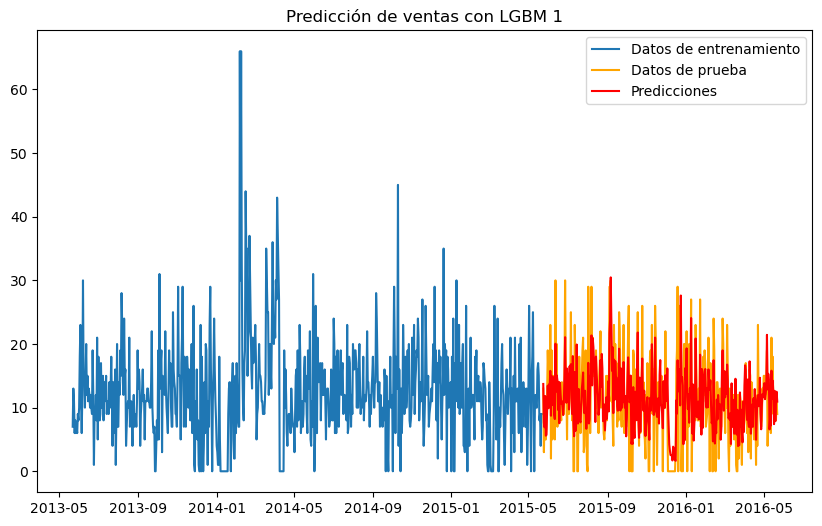

In [28]:
# Graficar los resultados: Datos de entrenamiento, prueba y predicciones
plt.figure(figsize=(10, 6))

# Graficar datos de entrenamiento
plt.plot(train.index, y_train, label='Datos de entrenamiento')

# Graficar datos de prueba
plt.plot(test.index, y_test, label='Datos de prueba', color='orange')

# Graficar las predicciones del modelo
plt.plot(test.index, predicciones, label='Predicciones', color='red')

# Añadir título y leyenda
plt.title('Predicción de ventas con LGBM 1')
plt.legend()
plt.show()

In [29]:
# Paso 10: Evaluar el rendimiento del modelo
mae = mean_absolute_error(y_test, predicciones)
rmse = np.sqrt(mean_squared_error(y_test, predicciones))

print(f'MAE: {mae}')
print(f'RMSE: {rmse}')

MAE: 4.05210308511648
RMSE: 5.159346550296846


In [30]:
# Obtener la importancia de las características del modelo entrenado
importancia_features = best_model.feature_importances_
features = X_train.columns

# Crear un DataFrame con los resultados
importancia_df = pd.DataFrame({'Feature': features, 'Importance': importancia_features})

# Ordenar por importancia
importancia_df = importancia_df.sort_values(by='Importance', ascending=False)

# Mostrar las características más importantes
print(importancia_df)

                    Feature  Importance
6          sales_moving_avg         361
2               sales_lag_1         246
3               sales_lag_2         228
8          cumulative_sales         145
9               day_of_week         130
5              week_of_year         125
4                     month          55
1                   snap_CA          35
7   price_promo_interaction           5
0                sell_price           0
10         price_volatility           0
11                  quarter           0


## **Optimización del modelo predictivo LightGBM a nivel de ítem (foods_2_347)**

In [32]:
# Crear nuevas características
df_foods_2_347_agg['day_of_month'] = df_foods_2_347_agg.index.day
df_foods_2_347_agg['is_weekend'] = np.where(df_foods_2_347_agg.index.weekday >= 5, 1, 0)

# Media móvil ponderada
df_foods_2_347_agg['sales_weighted_moving_avg'] = df_foods_2_347_agg['sales_total'].rolling(window=7).apply(lambda x: np.average(x, weights=np.arange(1, len(x) + 1)))

# Ventas acumuladas del mes
df_foods_2_347_agg['monthly_cumulative_sales'] = df_foods_2_347_agg.groupby(df_foods_2_347_agg.index.month)['sales_total'].cumsum()

# Ventas con retraso de 7 días (sales_lag_7)
df_foods_2_347_agg['sales_lag_7'] = df_foods_2_347_agg['sales_total'].shift(7)

# Rellenar valores NaN en sales_weighted_moving_avg y sales_lag_7 con el método 'bfill' (hacia atrás)
df_foods_2_347_agg['sales_weighted_moving_avg'].fillna(method='bfill', inplace=True)
df_foods_2_347_agg['sales_lag_7'].fillna(method='bfill', inplace=True)

In [33]:
# Restaurar el índice 'date' como una columna antes de guardar
df_reset = df_foods_2_347_agg.reset_index()

# Guardar el archivo con la columna 'date'
df_reset.to_csv("df_foods_2_347_agg_final.csv", index=False)

In [117]:
df_reset.head(16)

,date,sales_total,sell_price,snap_CA,sales_lag_1,sales_lag_2,month,week_of_year,sales_moving_avg,price_promo_interaction,cumulative_sales,day_of_week,price_volatility,quarter,day_of_month,is_weekend,sales_weighted_moving_avg,monthly_cumulative_sales,sales_lag_7
0,2013-05-22,7,2.0,0,7.0,7.0,5,21,7.000000,0.0,7,2,0.000345,2,22,0,7.678571,7,7.0
1,2013-05-23,13,2.0,0,7.0,7.0,5,21,10.000000,0.0,20,3,0.000000,2,23,0,7.678571,20,7.0
2,2013-05-24,11,2.0,0,13.0,7.0,5,21,10.333333,0.0,31,4,0.000000,2,24,0,7.678571,31,7.0
3,2013-05-25,6,2.0,0,11.0,13.0,5,21,9.250000,0.0,37,5,0.000000,2,25,1,7.678571,37,7.0
4,2013-05-26,8,2.0,0,6.0,11.0,5,21,9.500000,0.0,45,6,0.000000,2,26,1,7.678571,45,7.0
5,2013-05-27,6,2.0,0,8.0,6.0,5,22,7.750000,0.0,51,0,0.000000,2,27,0,7.678571,51,7.0
6,2013-05-28,7,2.0,0,6.0,8.0,5,22,6.750000,0.0,58,1,0.000000,2,28,0,7.678571,58,7.0
7,2013-05-29,6,2.0,0,7.0,6.0,5,22,6.750000,0.0,64,2,0.000000,2,29,0,7.107143,64,7.0
8,2013-05-30,9,2.0,0,6.0,7.0,5,22,7.000000,0.0,73,3,0.000000,2,30,0,7.321429,73,13.0
9,2013-05-31,8,2.0,0,9.0,6.0,5,22,7.500000,0.0,81,4,0.000000,2,31,0,7.428571,81,11.0


In [119]:
df_reset.tail(24)

,date,sales_total,sell_price,snap_CA,sales_lag_1,sales_lag_2,month,week_of_year,sales_moving_avg,price_promo_interaction,cumulative_sales,day_of_week,price_volatility,quarter,day_of_month,is_weekend,sales_weighted_moving_avg,monthly_cumulative_sales,sales_lag_7
1073,2016-04-29,13,2.24,0,8.0,7.0,4,17,9.25,0.00,13086,4,0.0,2,29,0,10.071429,1008,23.0
1074,2016-04-30,12,2.24,0,13.0,8.0,4,17,10.00,0.00,13098,5,0.0,2,30,1,10.500000,1020,11.0
1075,2016-05-01,15,2.24,1,12.0,13.0,5,17,12.00,2.24,13113,6,0.0,2,1,1,11.642857,818,11.0
1076,2016-05-02,15,2.24,1,15.0,12.0,5,18,13.75,2.24,13128,0,0.0,2,2,0,12.642857,833,13.0
1077,2016-05-03,12,2.24,1,15.0,15.0,5,18,13.50,2.24,13140,1,0.0,2,3,0,12.821429,845,9.0
1078,2016-05-04,14,2.24,1,12.0,15.0,5,18,14.00,2.24,13154,2,0.0,2,4,0,13.392857,859,7.0
1079,2016-05-05,15,2.24,1,14.0,12.0,5,18,14.00,2.24,13169,3,0.0,2,5,0,13.964286,874,8.0
1080,2016-05-06,19,2.24,1,15.0,14.0,5,18,15.00,2.24,13188,4,0.0,2,6,0,15.285714,893,13.0
1081,2016-05-07,4,2.24,1,19.0,15.0,5,18,13.00,2.24,13192,5,0.0,2,7,1,12.642857,897,12.0
1082,2016-05-08,9,2.24,1,4.0,19.0,5,18,11.75,2.24,13201,6,0.0,2,8,1,11.535714,906,15.0


In [34]:
# Paso 1: Definir la variable objetivo y las características
target = 'sales_total'
features = df_foods_2_347_agg.columns.drop(target)

In [35]:
# Paso 2: Dividir los datos en entrenamiento y prueba (últimos 12 meses para test)
test_size = 365  # Últimos 12 meses
train = df_foods_2_347_agg.iloc[:-test_size]  # Todo menos los últimos 12 meses para entrenamiento
test = df_foods_2_347_agg.iloc[-test_size:]   # Los últimos 12 meses para prueba

In [36]:
# Features y variable objetivo
X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]

In [37]:
# Paso 3: Preparar los datasets para LightGBM
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test)

In [38]:
# Paso 4: Definir el espacio de búsqueda de hiperparámetros
param_dist = {
    'num_leaves': np.arange(20, 150, 10),
    'max_depth': np.arange(3, 15, 1),
    'learning_rate': np.linspace(0.01, 0.3, 10),
    'n_estimators': np.arange(50, 300, 50),
    'subsample': np.linspace(0.6, 1.0, 5),
    'colsample_bytree': np.linspace(0.6, 1.0, 5),
    'reg_alpha': np.linspace(0, 1, 10),
    'reg_lambda': np.linspace(0, 1, 10)
}

In [39]:
# Paso 5: Crear el modelo LightGBM con el envoltorio de Scikit-Learn
model_lgb = lgb.LGBMRegressor(boosting_type='gbdt', objective='regression', verbose=-1)  # Silenciar LightGBM

In [40]:
# Paso 6: Configurar la búsqueda aleatoria con validación cruzada
random_search = RandomizedSearchCV(
    estimator=model_lgb, 
    param_distributions=param_dist,
    n_iter=50,  # Número de combinaciones a probar
    scoring='neg_mean_squared_error',  # Métrica de evaluación
    cv=3,  # Validación cruzada
    verbose=0,  # Evitar mensajes durante la optimización
    random_state=42,
    n_jobs=-1  # Usar todos los núcleos disponibles para acelerar
)

In [41]:
# Paso 7: Ajustar el modelo usando RandomizedSearchCV
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=LGBMRegressor(objective='regression', verbose=-1),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'colsample_bytree': array([0.6, 0.7, 0.8, 0.9, 1. ]),
                                        'learning_rate': array([0.01      , 0.04222222, 0.07444444, 0.10666667, 0.13888889,
       0.17111111, 0.20333333, 0.23555556, 0.26777778, 0.3       ]),
                                        'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
                                        'n_esti...
                                        'num_leaves': array([ 20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130, 140]),
                                        'reg_alpha': array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ]),
                                        'reg_lambda': array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ]),
                                        'subsample': array([0.6, 0.7, 0.8, 0.9, 1. ])},
                   random_state=42, scoring='neg_mean_squared_error')

In [42]:
# Ver los mejores hiperparámetros encontrados
print(f'Mejores hiperparámetros: {random_search.best_params_}')

Mejores hiperparámetros: {'subsample': 0.8, 'reg_lambda': 0.8888888888888888, 'reg_alpha': 0.1111111111111111, 'num_leaves': 80, 'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.1388888888888889, 'colsample_bytree': 0.9}


In [43]:
# Paso 8: Entrenar el modelo con los mejores hiperparámetros
best_model = lgb.LGBMRegressor(**random_search.best_params_)
best_model.fit(X_train, y_train)

LGBMRegressor(colsample_bytree=0.9, learning_rate=0.1388888888888889,
              max_depth=4, n_estimators=200, num_leaves=80,
              reg_alpha=0.1111111111111111, reg_lambda=0.8888888888888888,
              subsample=0.8)

In [44]:
# Paso 9: Hacer predicciones con el conjunto de prueba
predicciones_finales = best_model.predict(X_test)

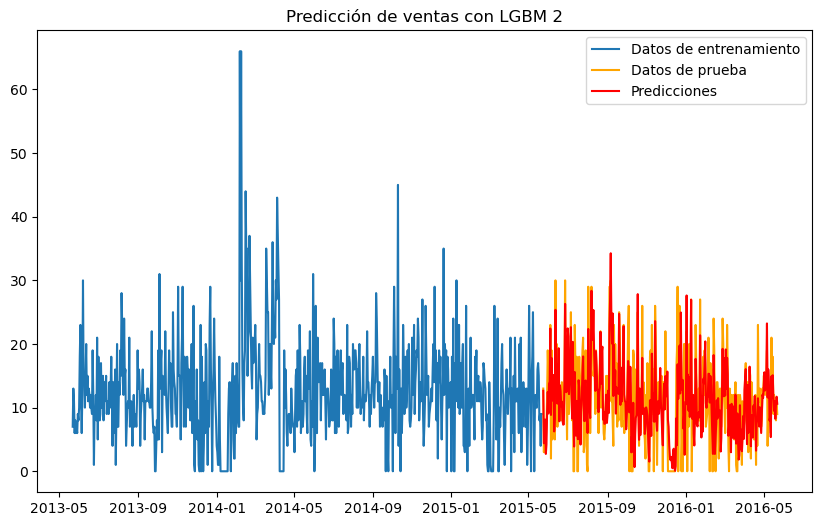

In [45]:
# Graficar los resultados
plt.figure(figsize=(10, 6))

# Graficar datos de entrenamiento
plt.plot(train.index, y_train, label='Datos de entrenamiento')

# Graficar datos de prueba
plt.plot(test.index, y_test, label='Datos de prueba', color='orange')

# Graficar las predicciones del modelo
plt.plot(test.index, predicciones_finales, label='Predicciones', color='red')

# Añadir título y leyenda
plt.title('Predicción de ventas con LGBM 2')
plt.legend()
plt.show()

In [46]:
# Paso 10: Evaluar el rendimiento del modelo
mae_final = mean_absolute_error(y_test, predicciones_finales)
rmse_final = np.sqrt(mean_squared_error(y_test, predicciones_finales))

print(f'MAE final: {mae_final}')
print(f'RMSE final: {rmse_final}')

MAE final: 3.729951889246138
RMSE final: 4.786013719569233


In [47]:
# Obtener la importancia de las características del modelo entrenado
importancia_features = best_model.feature_importances_
features = X_train.columns

# Crear un DataFrame con los resultados
importancia_df = pd.DataFrame({'Feature': features, 'Importance': importancia_features})

# Ordenar por importancia
importancia_df = importancia_df.sort_values(by='Importance', ascending=False)

# Mostrar las características más importantes
print(importancia_df)

                      Feature  Importance
14  sales_weighted_moving_avg         307
6            sales_moving_avg         204
3                 sales_lag_2         156
2                 sales_lag_1         135
12               day_of_month         135
9                 day_of_week         104
8            cumulative_sales          93
5                week_of_year          93
16                sales_lag_7          91
15   monthly_cumulative_sales          83
4                       month          30
1                     snap_CA          11
13                 is_weekend           2
7     price_promo_interaction           1
10           price_volatility           0
11                    quarter           0
0                  sell_price           0


In [48]:
#Guardar las predicciones en una variable
predicciones = best_model.predict(X_test)

## **Evaluar y validar el modelo predictivo**

In [50]:
# Validación cruzada de 5 pliegues
scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

# Convertir los resultados a RMSE y mostrar por pliegue
rmse_scores = np.sqrt(-scores)
print(f'RMSE por pliegue: {rmse_scores}')
print(f'RMSE promedio: {rmse_scores.mean()}')

RMSE por pliegue: [3.4715361  6.92874916 5.35489336 4.41924488 4.59217948]
RMSE promedio: 4.953320597820173


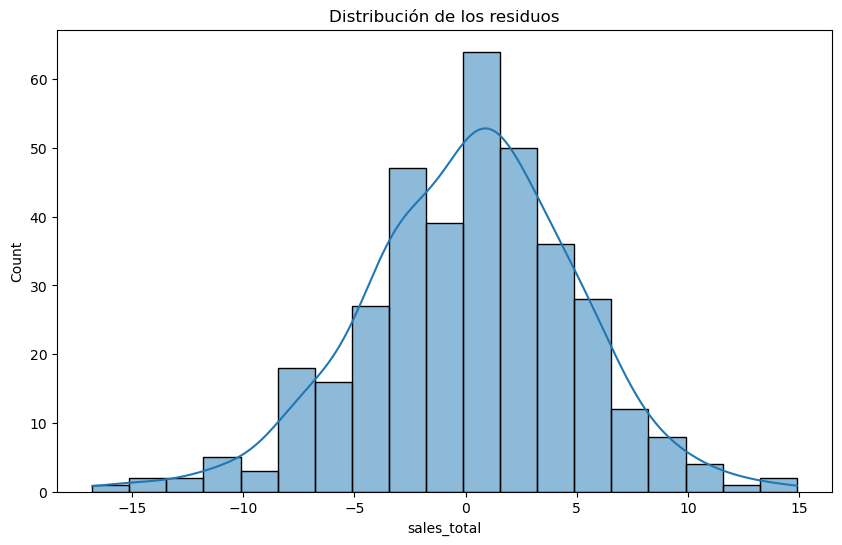

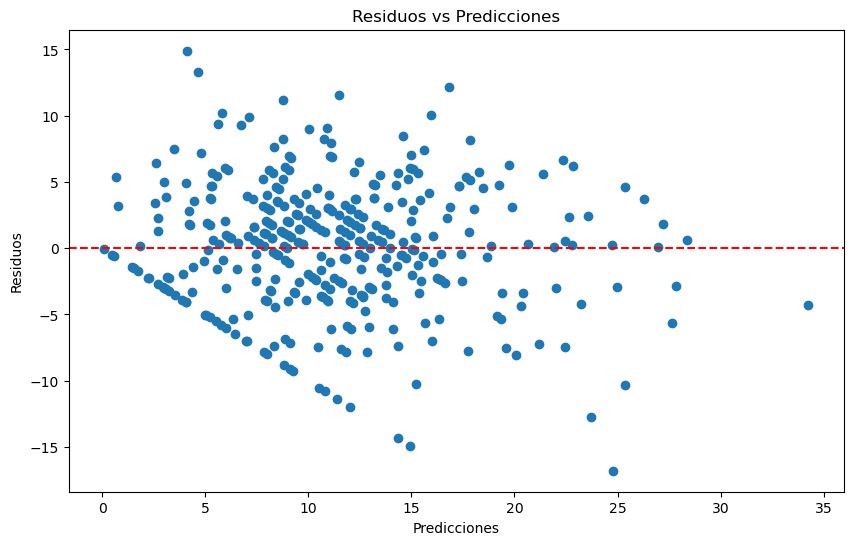

In [51]:
# Calcular los residuos
residuos = y_test - predicciones

# Graficar la distribución de los residuos
plt.figure(figsize=(10, 6))
sns.histplot(residuos, kde=True)
plt.title('Distribución de los residuos')
plt.show()

# Graficar residuos vs predicciones
plt.figure(figsize=(10, 6))
plt.scatter(predicciones, residuos)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuos vs Predicciones')
plt.xlabel('Predicciones')
plt.ylabel('Residuos')
plt.show()

In [52]:
# Evaluar rendimiento en el conjunto de entrenamiento
train_predicciones = best_model.predict(X_train)
mae_train = mean_absolute_error(y_train, train_predicciones)
rmse_train = np.sqrt(mean_squared_error(y_train, train_predicciones))

# Evaluar rendimiento en el conjunto de prueba
mae_test = mean_absolute_error(y_test, predicciones)
rmse_test = np.sqrt(mean_squared_error(y_test, predicciones))

print(f'Rendimiento en Entrenamiento - MAE: {mae_train}, RMSE: {rmse_train}')
print(f'Rendimiento en Prueba - MAE: {mae_test}, RMSE: {rmse_test}')

Rendimiento en Entrenamiento - MAE: 1.5779853638393124, RMSE: 2.1772627363896686
Rendimiento en Prueba - MAE: 3.729951889246138, RMSE: 4.786013719569233


## **Post-procesamiento del modelo predictivo: ajustar día de cierre de la tienda el 25 de diciembre con ventas 0**

In [54]:
# Crear una copia de las predicciones para no alterar las originales, convirtiéndolas a pandas Series con el índice de test
predicciones_ajustadas = pd.Series(predicciones_finales, index=test.index)

# Asegurarse de que las fechas de cierre estén en el conjunto de prueba
# En lugar de usar el índice original, nos basamos en el índice del conjunto de prueba (test)
dias_cierre = test[(test.index.month == 12) & (test.index.day == 25)].index

# Ajustar las predicciones a 0 en esos días específicos
predicciones_ajustadas.loc[dias_cierre] = 0

# Mostrar las predicciones ajustadas para verificar
print(predicciones_ajustadas[dias_cierre])

date
2015-12-25    0.0
dtype: float64


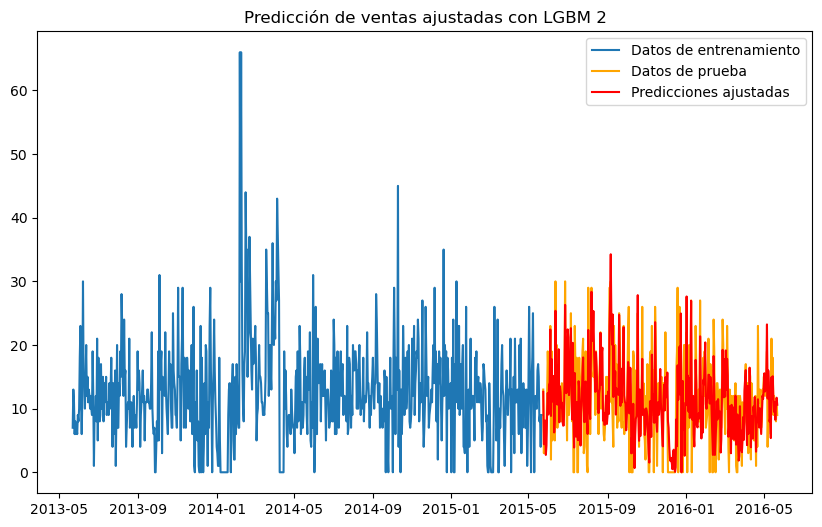

In [55]:
# Graficar los resultados después del ajuste
plt.figure(figsize=(10, 6))

# Graficar datos de entrenamiento
plt.plot(train.index, y_train, label='Datos de entrenamiento')

# Graficar datos de prueba
plt.plot(test.index, y_test, label='Datos de prueba', color='orange')

# Graficar las predicciones ajustadas
plt.plot(test.index, predicciones_ajustadas, label='Predicciones ajustadas', color='red')

# Añadir título y leyenda
plt.title('Predicción de ventas ajustadas con LGBM 2')
plt.legend()
plt.show()

In [56]:
# Calcular el MAE y RMSE para las predicciones ajustadas
mae_ajustado = mean_absolute_error(y_test, predicciones_ajustadas)
rmse_ajustado = np.sqrt(mean_squared_error(y_test, predicciones_ajustadas))

# Mostrar los resultados
print(f'MAE ajustado: {mae_ajustado}')
print(f'RMSE ajustado: {rmse_ajustado}')

MAE ajustado: 3.689015314164703
RMSE ajustado: 4.72167969725019


In [57]:
# Guardar modelos
joblib.dump(best_model, "item_model.pkl")

['item_model.pkl']